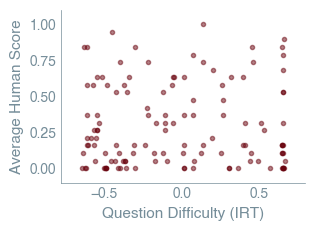

In [49]:
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.constants import golden

def plot_difficulty_vs_mean_scores(human_file, filtered_file, trace_file):
    # Load files
    with open(human_file, 'rb') as f:
        human_data = pickle.load(f)
    
    with open(filtered_file, 'rb') as f:
        filtered_data = pickle.load(f)
    
    with open(trace_file, 'rb') as f:
        trace_data = pickle.load(f)

    # Get scores for each human
    all_scores = []
    for human_id in human_data['raw_scores'].keys():
        human_df = human_data['raw_scores'][human_id]
        scores = pd.DataFrame(index=human_df.index)
        scores['all_correct'] = human_df['all_correct_'].astype(int)
        all_scores.append(scores)
    
    combined_scores = pd.concat(all_scores, axis=1)
    mean_scores = combined_scores.mean(axis=1)
    
    # Get Mistral data and find matching indices
    mistral_df = pd.DataFrame(filtered_data['overall']['Mistral-Large-2'])
    human_indices = mean_scores.index
    mistral_indices = mistral_df['Unnamed: 0'].values
    matching_indices = [idx for idx, val in enumerate(human_indices) if val in mistral_indices]
    
    # Get difficulty values and corresponding scores
    difficulty_vector = trace_data.posterior['difficulties'].mean(dim=['chain', 'draw']).values
    matched_difficulties = difficulty_vector[matching_indices]
    matched_scores = mean_scores.iloc[matching_indices]
    
    # Plot settings
    ONE_COL_WIDTH_INCH = 3.25
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
    plt.style.use('../nbs/lamalab.mplstyle')
    
    # Create figure with white background
    fig, ax = plt.subplots(figsize=(ONE_COL_WIDTH_INCH, 1.2 * ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')
    
    # Remove grid
    ax.grid(False)
    
    # Create scatter plot with improved styling
    scatter = ax.scatter(matched_difficulties, matched_scores, alpha=0.5, color='#6A040F')
    
    # Add trend line
    #z = np.polyfit(matched_difficulties, matched_scores, 1)
    #p = np.poly1d(z)
    #ax.plot(matched_difficulties, p(matched_difficulties), "--", color='#6A040F', alpha=0.8)
    
    # Calculate and add correlation
    #correlation = np.corrcoef(matched_difficulties, matched_scores)[0,1]
    #ax.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
            #transform=ax.transAxes,
            #bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Add margins to create space between points and axes
    ax.margins(x=0.1, y=0.1)
    
    # Customize labels and title
    ax.set_xlabel('Question Difficulty (IRT)')
    ax.set_ylabel('Average Human Score')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig('difficulty_human_scores.pdf', bbox_inches='tight', dpi=300)
    
    return fig

# Create plot
fig = plot_difficulty_vs_mean_scores(
    '../data/humans_as_models_scores_combined.pkl',
    '../data/filtered_model_score_dict.pkl',
    '../data/trace_all_correct_filtered.pkl'
)
plt.show()